In [1]:
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
from age_prediction.models.\
    efficientnet_pytorch_3d import EfficientNet3D as EfNetB0
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
%matplotlib inline

In [ ]:
def MAE_pred(y_pred, y_true):
    mae = nn.L1Loss(reduction='mean')(y_pred, y_true).cpu().detach().numpy().item()
    return np.round(mae, 2)
def MSE_pred(y_pred, y_true):
    mse = nn.MSELoss()(y_pred, y_true).cpu().detach().numpy().item()
    return np.round(mse, 2)
def delta_pred(y_pred, y_true):
    delta = y_pred - y_true
    return np.mean(delta).round(2)

In [3]:
def ensemble(left, right):
    right = right[['Name', 'Pred']]
    ensemble = pd.merge(left, right, on=['Name'], suffixes=("_L", "_R"))
    ensemble['Pred'] = ensemble.apply(lambda x: (x['Pred_L']+x['Pred_R'])/2, axis=1)
    return ensemble

In [31]:
def metrics(preds):
    print("MAE", MAE_pred(torch.from_numpy(preds['Pred'].values), torch.from_numpy(preds['True'].values)))
    mse = MSE_pred(torch.from_numpy(preds['Pred'].values), torch.from_numpy(preds['True'].values))
    print("MSE", mse)
    print("RMSE", np.round(np.sqrt(mse), 2))
    print("Delta", delta_pred(preds['Pred'], preds['True']))

In [5]:
def plot_regression(dt, lim):
    dt = dt[['Name', 'True', 'Pred']].copy()
    dt.columns = ['Image Filename', 'Chronological age', 'Estimated age']

    pearson = pg.corr(dt['Estimated age'], dt['Chronological age'])
    # display(pearson)

    sns.set(style='white', font_scale=1.2)
    g = sns.JointGrid(data=dt, x='Chronological age', y='Estimated age',
                    xlim=lim, ylim=lim, height=5)
    g.plot_joint(sns.regplot, color="xkcd:muted blue")
    g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
    g.ax_joint.text(lim[0]+2, lim[1]-2, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, '-r')
    plt.tight_layout()

In [6]:
def bias_corr(val, label, test):
    a, b, _, _, _ = scipy.stats.linregress(val, label)
    return pd.Series((test - b)/a)

Left
MAE 4.8
MSE 39.56
RMSE 6.29
Delta 0.49
Right
MAE 4.24
MSE 33.76
RMSE 5.81
Delta -0.04
Left+Right
MAE 3.87
MSE 25.11
RMSE 5.01
Delta 0.23


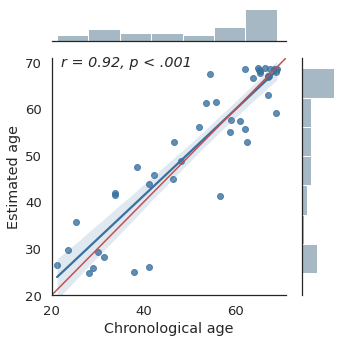

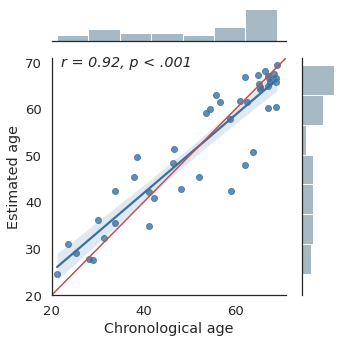

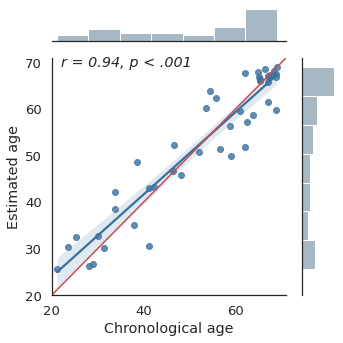

In [32]:
# Validation 0-70
val_L = pd.read_csv("predict_results/val_0-70_L.csv")
val_R = pd.read_csv("predict_results/val_0-70_R.csv")
ens = ensemble(val_L, val_R)
ens.to_csv('predict_results/val_0-70_LR.csv', index=False)
print("Left")
metrics(val_L)
plot_regression(val_L, (20,71))
print("Right")
metrics(val_R)
plot_regression(val_R, (20,71))
print("Left+Right")
metrics(ens)
plot_regression(ens, (20,71))

Left
MAE 4.24
MSE 36.33
RMSE 6.03
Delta 0.17
Right
MAE 4.71
MSE 37.32
RMSE 6.11
Delta -1.54
Left+Right
MAE 3.31
MSE 21.62
RMSE 4.65
Delta -0.68


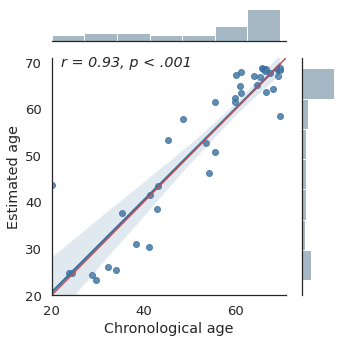

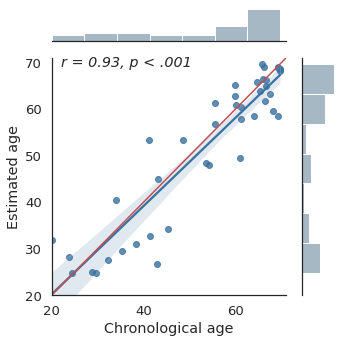

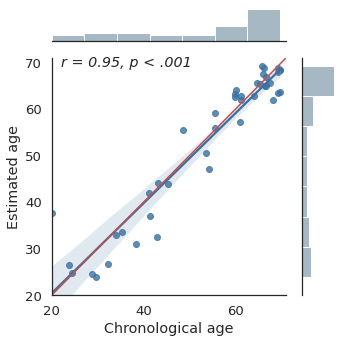

In [40]:
# Test 0-70
val_L = pd.read_csv("predict_results/test_0-70_L.csv")
val_R = pd.read_csv("predict_results/test_0-70_R.csv")
ens = ensemble(val_L, val_R)
ens.to_csv('predict_results/test_0-70_LR.csv', index=False)
print("Left")
metrics(val_L)
plot_regression(val_L, (20,71))
print("Right")
metrics(val_R)
plot_regression(val_R, (20,71))
print("Left+Right")
metrics(ens)
plot_regression(ens, (20,71))

In [41]:
np.round(np.sqrt(25.11), 2)

5.01

In [45]:
ens['Delta'] = ens[['True', 'Pred']].apply(lambda x: x[1]-x[0], axis=1)
ens['DeltaL'] = ens[['True', 'Pred_L']].apply(lambda x: x[1]-x[0], axis=1)
ens['DeltaR'] = ens[['True', 'Pred_R']].apply(lambda x: x[1]-x[0], axis=1)
ens[ens['True'] > 40].sort_values('True')
# ens

,Name,True,Pred_L,Pred_R,Pred,Delta,DeltaL,DeltaR
23,IXI063-Guys-0742-T1,41.12,30.330976,53.410393,41.870685,0.750685,-10.789024,12.290393
41,IXI584-Guys-1129-T1,41.33,41.491955,32.638668,37.065311,-4.264688,0.161955,-8.691332
39,IXI566-HH-2535-T1,42.97,38.456474,26.674578,32.565526,-10.404474,-4.513526,-16.295422
33,IXI108-Guys-0865-T1,43.16,43.432926,44.975240,44.204083,1.044083,0.272926,1.815240
40,IXI588-IOP-1158-T1,45.30,53.410103,34.276920,43.843512,-1.456488,8.110103,-11.023080
18,IXI221-HH-1606-T1,48.55,57.864803,53.299862,55.582332,7.032333,9.314803,4.749862
20,IXI396-HH-2115-T1,53.57,52.747124,48.475710,50.611417,-2.958583,-0.822876,-5.094290
21,IXI360-Guys-0912-T1,54.19,46.243965,47.937153,47.090559,-7.099441,-7.946035,-6.252847
17,IXI401-Guys-0978-T1,55.58,61.469580,56.877304,59.173442,3.593442,5.889580,1.297304
7,070_S_6191_ADNI_Screening,55.60,50.772030,61.235855,56.003943,0.403943,-4.827970,5.635855


Left
MAE 3.86
MSE 21.79
Delta 0.75
Right
MAE 4.0
MSE 26.27
Delta 1.64
Left+Right
MAE 3.71
MSE 20.27
Delta 1.19


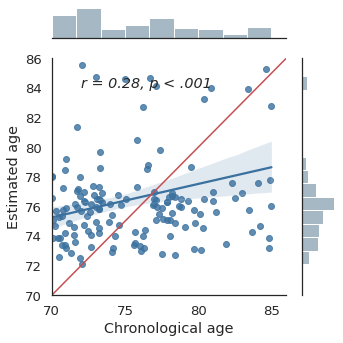

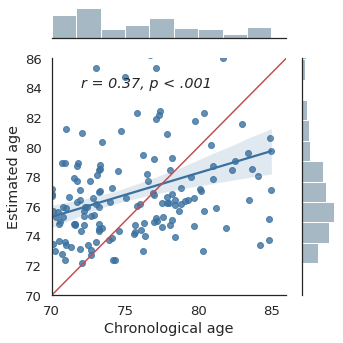

In [10]:
# Val 70-100
left = pd.read_csv("predict_results/val_70-100_L.csv")
right = pd.read_csv("predict_results/val_70-100_R.csv")
ens = ensemble(left, right)
ens.to_csv('predict_results/val_70-100_LR.csv', index=False)
print("Left")
metrics(left)
plot_regression(left, (70,86))
print("Right")
metrics(right)
# plot_regression(right, (70,86))
print("Left+Right")
metrics(ens)
plot_regression(ens, (70,86))

Left
MAE 3.73
MSE 20.47
Delta 0.77
Right
MAE 3.61
MSE 21.06
Delta 1.28
Left+Right
MAE 3.36
MSE 17.36
Delta 1.02


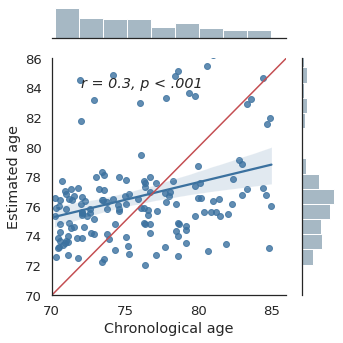

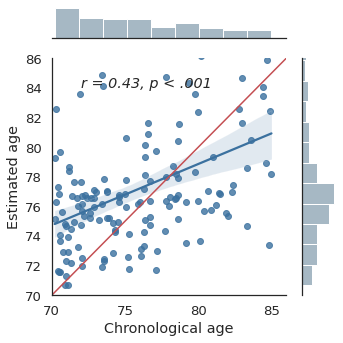

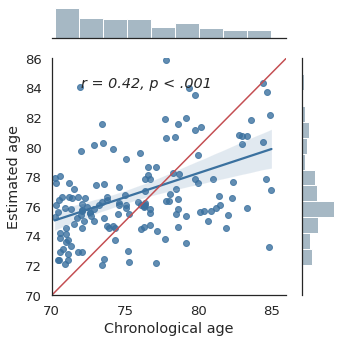

In [11]:
# Test 70-100
left = pd.read_csv("predict_results/test_70-100_L.csv")
right = pd.read_csv("predict_results/test_70-100_R.csv")
ens = ensemble(left, right)
ens.to_csv('predict_results/test_70-100_LR.csv', index=False)
print("Left")
metrics(left)
plot_regression(left, (70,86))
print("Right")
metrics(right)
plot_regression(right, (70,86))
print("Left+Right")
metrics(ens)
plot_regression(ens, (70,86))

Left
MAE 5.72
MSE 45.81
Delta 3.69
Right
MAE 6.82
MSE 68.31
Delta 5.96
Left+Right
MAE 5.77
MSE 48.34
Delta 4.82


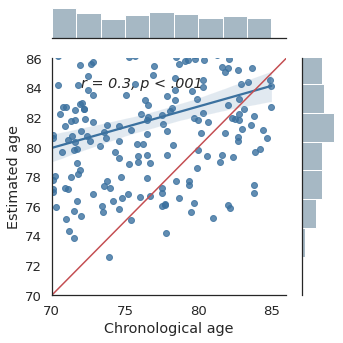

In [12]:
# AD
val_L = pd.read_csv("predict_results/ad_70-100_L.csv")
val_R = pd.read_csv("predict_results/ad_70-100_R.csv")
ens = ensemble(val_L, val_R)
ens.to_csv('predict_results/ad_70-100_LR.csv', index=False)
print("Left")
metrics(val_L)
# plot_regression(val_L, (70,86))
print("Right")
metrics(val_R)
# plot_regression(val_R, (70,86))
print("Left+Right")
metrics(ens)
plot_regression(ens, (70,86))

Left
MAE 4.95
MSE 38.1
Delta 2.19
Right
MAE 6.69
MSE 62.1
Delta 4.38
Left+Right
MAE 5.27
MSE 41.25
Delta 3.29


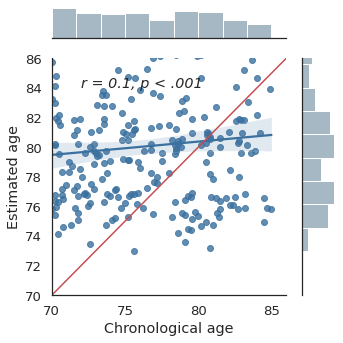

In [13]:
# MCI
val_L = pd.read_csv("predict_results/mci_70-100_L.csv")
val_R = pd.read_csv("predict_results/mci_70-100_R.csv")
ens = ensemble(val_L, val_R)
ens.to_csv('predict_results/mci_70-100_LR.csv', index=False)
print("Left")
metrics(val_L)
# plot_regression(val_L, (70,86))
print("Right")
metrics(val_R)
# plot_regression(val_R, (70,86))
print("Left+Right")
metrics(ens)
plot_regression(ens, (70,86))

In [125]:
import numpy as np

def plot_regression_sp(x, y):
    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=0, marker='s', label='Data points')
    ax.plot(x, intercept + slope * x, label=line)
    ax.set_xlabel('Chronological age')
    ax.set_ylabel('Delta')
    ax.legend(facecolor='white')
    plt.show()

def bias_corr(val, label, test):
    # Zero mean
    # print(val.min(), val.max())
    # print(test.min(), test.max())
    # _val = val - val.mean()
    # _label = label - label.mean()
    # plot_regression_sp(label, val)
    a, b, _, _, _ = scipy.stats.linregress(label, val)
    # val1 = pd.Series(((_val - b)/a))
    # val1 = val1 + val.mean()
    # print(val1.min(), val1.max())
    test = pd.Series((test - b)/a)
    # test = test + val.mean()
    # print(test.min(), test.max())
    return test

In [131]:
print("Test")
val_L = pd.read_csv("predict_results/val_70-100_L.csv")
val_R = pd.read_csv("predict_results/val_70-100_R.csv")
val = ensemble(val_L, val_R)
test_L = pd.read_csv("predict_results/test_70-100_L.csv")
test_R = pd.read_csv("predict_results/test_70-100_R.csv")
test = ensemble(test_L, test_R)
metrics(test)
test['Pred'] = bias_corr(val.Pred, val['True'], test.Pred)
metrics(test)
# plot_regression(test, (70,86))
test.to_csv('predict_results/test_70-100_LR_bias.csv', index=False)

print("AD")
test_L = pd.read_csv("predict_results/ad_70-100_L.csv")
test_R = pd.read_csv("predict_results/ad_70-100_R.csv")
test = ensemble(test_L, test_R)
metrics(test)
test['Pred'] = bias_corr(val.Pred, val['True'], test.Pred)
metrics(test)
# plot_regression(test, (70,86))
test.to_csv('predict_results/ad_70-100_LR_bias.csv', index=False)

print("MCI")
test_L = pd.read_csv("predict_results/mci_70-100_L.csv")
test_R = pd.read_csv("predict_results/mci_70-100_R.csv")
test = ensemble(test_L, test_R)
metrics(test)
test['Pred'] = bias_corr(val.Pred, val['True'], test.Pred)
metrics(test)
# plot_regression(test, (70,86))
test.to_csv('predict_results/mci_70-100_LR_bias.csv', index=False)

Test
MAE 3.36
MSE 17.36
Delta 1.02
MAE 7.38
MSE 96.28
Delta -0.45
AD
MAE 5.77
MSE 48.34
Delta 4.82
MAE 16.65
MSE 404.23
Delta 15.3
MCI
MAE 5.27
MSE 41.25
Delta 3.29
MAE 12.86
MSE 269.2
Delta 9.37


In [135]:
for hold in ['', '_h2']:
    val_L = pd.read_csv("predict_results/val_70-100_L" + hold + ".csv")
    val_R = pd.read_csv("predict_results/val_70-100_R" + hold + ".csv")
    val = ensemble(val_L, val_R)

    # Test 70-100
    print("Test")
    left = pd.read_csv("predict_results/test_70-100_L" + hold + ".csv")
    right = pd.read_csv("predict_results/test_70-100_R" + hold + ".csv")
    ens = ensemble(left, right)
    print("Left+Right")
    metrics(ens)
    ens['Pred'] = bias_corr(val.Pred, val['True'], ens.Pred)
    ens.to_csv("predict_results/test_70-100_LR_bias" + hold + ".csv", index=False)
    print("Left+Right -- bias")
    metrics(ens)
    # AD 70-100
    print("AD")
    left = pd.read_csv("predict_results/ad_70-100_L" + hold + ".csv")
    right = pd.read_csv("predict_results/ad_70-100_R" + hold + ".csv")
    ens = ensemble(left, right)
    print("Left+Right")
    metrics(ens)
    ens['Pred'] = bias_corr(val.Pred, val['True'], ens.Pred)
    ens.to_csv("predict_results/ad_70-100_LR_bias" + hold + ".csv", index=False)
    print("Left+Right -- bias")
    metrics(ens)
    # MCI 70-100
    print("MCI")
    left = pd.read_csv("predict_results/mci_70-100_L" + hold + ".csv")
    right = pd.read_csv("predict_results/mci_70-100_R" + hold + ".csv")
    ens = ensemble(left, right)
    print("Left+Right")
    metrics(ens)
    ens['Pred'] = bias_corr(val.Pred, val['True'], ens.Pred)
    ens.to_csv("predict_results/mci_70-100_LR_bias" + hold + ".csv", index=False)
    print("Left+Right -- bias")
    metrics(ens)

print("Joined")
ad_1 = pd.read_csv("predict_results/mci_70-100_LR_bias.csv")
ad_2 = pd.read_csv("predict_results/mci_70-100_LR_bias_h2.csv")
cols = ['Name', 'True', 'Pred']
ens = ensemble(ad_1[cols], ad_2[cols])
metrics(ens)
ens.to_csv("predict_results/mci_70-100_LR_holds_bias.csv", index=False)

ad_1 = pd.read_csv("predict_results/ad_70-100_LR_bias.csv")
ad_2 = pd.read_csv("predict_results/ad_70-100_LR_bias_h2.csv")
cols = ['Name', 'True', 'Pred']
ens = ensemble(ad_1[cols], ad_2[cols])
metrics(ens)
ens.to_csv("predict_results/ad_70-100_LR_holds_bias.csv", index=False)

cn_1 = pd.read_csv("predict_results/test_70-100_LR_bias.csv")
cn_2 = pd.read_csv("predict_results/test_70-100_LR_bias_h2.csv")
cols = ['Name', 'True', 'Pred']
cns = pd.concat([cn_1[cols], cn_2[cols]])
cns.to_csv("predict_results/test_70-100_LR_holds_bias.csv", index=False)
metrics(cns)

Test
Left+Right
MAE 3.36
MSE 17.36
Delta 1.02
Left+Right -- bias
MAE 7.38
MSE 96.28
Delta -0.45
AD
Left+Right
MAE 5.77
MSE 48.34
Delta 4.82
Left+Right -- bias
MAE 16.65
MSE 404.23
Delta 15.3
MCI
Left+Right
MAE 5.27
MSE 41.25
Delta 3.29
Left+Right -- bias
MAE 12.86
MSE 269.2
Delta 9.37
Test
Left+Right
MAE 3.95
MSE 24.64
Delta 1.45
Left+Right -- bias
MAE 7.91
MSE 105.22
Delta 2.55
AD
Left+Right
MAE 6.0
MSE 53.86
Delta 5.19
Left+Right -- bias
MAE 15.63
MSE 345.14
Delta 14.57
MCI
Left+Right
MAE 5.38
MSE 42.37
Delta 3.52
Left+Right -- bias
MAE 12.39
MSE 228.59
Delta 9.65
Joined
MAE 12.15
MSE 231.22
Delta 9.51
MAE 15.94
MSE 362.24
Delta 14.93
MAE 7.65
MSE 100.75
Delta 1.05


Val
Left
MAE 3.86
MSE 21.79
Delta 0.75
Right
MAE 4.0
MSE 26.27
Delta 1.64
Left+Right
MAE 3.71
MSE 20.27
Delta 1.19
Test
Left
MAE 3.73
MSE 20.47
Delta 0.77
Right
MAE 3.61
MSE 21.06
Delta 1.28
Left+Right
MAE 3.36
MSE 17.36
Delta 1.02
AD
Left
MAE 5.72
MSE 45.81
Delta 3.69
Right
MAE 6.82
MSE 68.31
Delta 5.96
Left+Right
MAE 5.77
MSE 48.34
Delta 4.82
MCI
Left
MAE 4.95
MSE 38.1
Delta 2.19
Right
MAE 6.69
MSE 62.1
Delta 4.38
Left+Right
MAE 5.27
MSE 41.25
Delta 3.29
Val
Left
MAE 3.63
MSE 22.42
Delta -0.02
Right
MAE 3.71
MSE 22.24
Delta 0.94
Left+Right
MAE 3.32
MSE 18.35
Delta 0.46
Test
Left
MAE 4.36
MSE 32.03
Delta 0.87
Right
MAE 4.31
MSE 28.47
Delta 2.03
Left+Right
MAE 3.95
MSE 24.64
Delta 1.45
AD
Left
MAE 5.77
MSE 51.28
Delta 4.07
Right
MAE 7.08
MSE 71.89
Delta 6.3
Left+Right
MAE 6.0
MSE 53.86
Delta 5.19
MCI
Left
MAE 5.32
MSE 43.93
Delta 2.22
Right
MAE 6.54
MSE 59.92
Delta 4.82
Left+Right
MAE 5.38
MSE 42.37
Delta 3.52


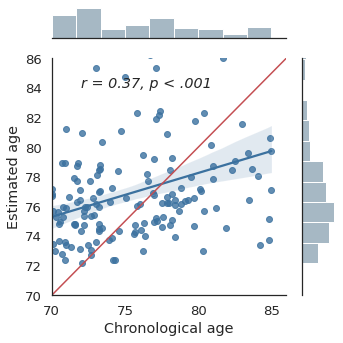

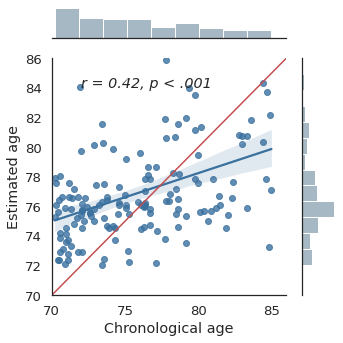

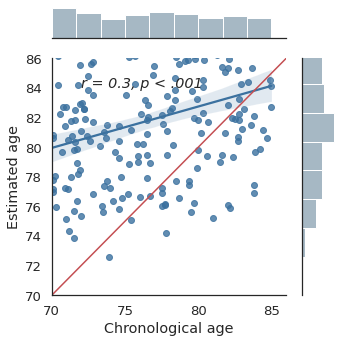

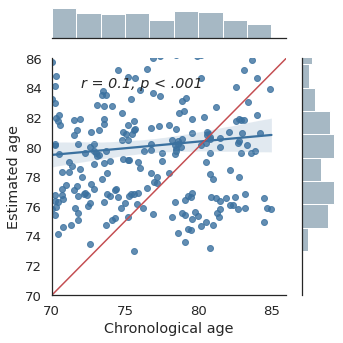

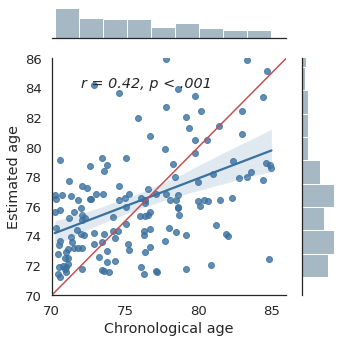

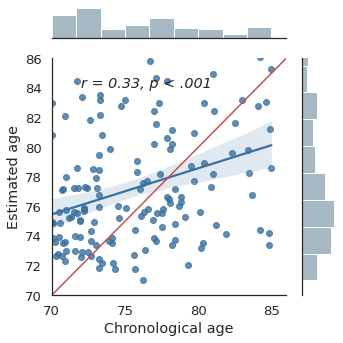

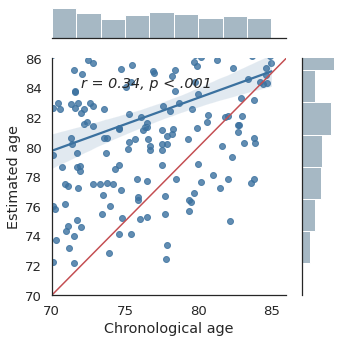

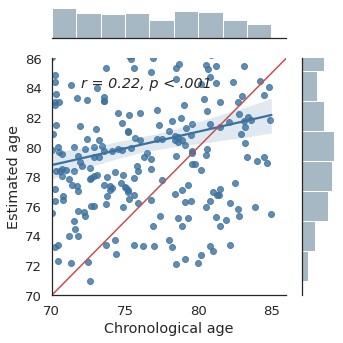

In [136]:
for hold in ['', '_h2']:
    # Val 70-100
    print("Val")
    left = pd.read_csv("predict_results/val_70-100_L" + hold + ".csv")
    right = pd.read_csv("predict_results/val_70-100_R" + hold + ".csv")
    ens = ensemble(left, right)
    ens.to_csv("predict_results/val_70-100_LR" + hold + ".csv", index=False)
    print("Left")
    metrics(left)
    # plot_regression(left, (70,86))
    print("Right")
    metrics(right)
    # plot_regression(right, (70,86))
    print("Left+Right")
    metrics(ens)
    plot_regression(ens, (70,86))
    print("Test")
    # Test 70-100
    left = pd.read_csv("predict_results/test_70-100_L" + hold + ".csv")
    right = pd.read_csv("predict_results/test_70-100_R" + hold + ".csv")
    ens = ensemble(left, right)
    ens.to_csv("predict_results/test_70-100_LR" + hold + ".csv", index=False)
    print("Left")
    metrics(left)
    # plot_regression(left, (70,86))
    print("Right")
    metrics(right)
    # plot_regression(right, (70,86))
    print("Left+Right")
    metrics(ens)
    plot_regression(ens, (70,86))
    # AD
    print("AD")
    val_L = pd.read_csv("predict_results/ad_70-100_L" + hold + ".csv")
    val_R = pd.read_csv("predict_results/ad_70-100_R" + hold + ".csv")
    ens = ensemble(val_L, val_R)
    ens.to_csv("predict_results/ad_70-100_LR" + hold + ".csv", index=False)
    print("Left")
    metrics(val_L)
    print("Right")
    metrics(val_R)
    print("Left+Right")
    metrics(ens)
    plot_regression(ens, (70,86))
    # MCI
    print("MCI")
    val_L = pd.read_csv("predict_results/mci_70-100_L" + hold + ".csv")
    val_R = pd.read_csv("predict_results/mci_70-100_R" + hold + ".csv")
    ens = ensemble(val_L, val_R)
    ens.to_csv("predict_results/mci_70-100_LR" + hold + ".csv", index=False)
    print("Left")
    metrics(val_L)
    print("Right")
    metrics(val_R)
    print("Left+Right")
    metrics(ens)
    plot_regression(ens, (70,86))

In [140]:
print("Left+Right")
print("Val")
cn_1 = pd.read_csv("predict_results/val_70-100_LR.csv")
cn_2 = pd.read_csv("predict_results/val_70-100_LR_h2.csv")
cols = ['Name', 'True', 'Pred']
cns = pd.concat([cn_1[cols], cn_2[cols]])
cns.to_csv("predict_results/val_70-100_LR_holds.csv", index=False)
metrics(cns)

print("Test")
cn_1 = pd.read_csv("predict_results/test_70-100_LR.csv")
cn_2 = pd.read_csv("predict_results/test_70-100_LR_h2.csv")
cols = ['Name', 'True', 'Pred']
cns = pd.concat([cn_1[cols], cn_2[cols]])
cns.to_csv("predict_results/test_70-100_LR_holds.csv", index=False)
metrics(cns)

print("MCI")
ad_1 = pd.read_csv("predict_results/mci_70-100_LR.csv")
ad_2 = pd.read_csv("predict_results/mci_70-100_LR_h2.csv")
cols = ['Name', 'True', 'Pred']
ens = ensemble(ad_1[cols], ad_2[cols])
ens.to_csv("predict_results/mci_70-100_LR_holds.csv", index=False)
metrics(ens)

print("AD")
ad_1 = pd.read_csv("predict_results/ad_70-100_LR.csv")
ad_2 = pd.read_csv("predict_results/ad_70-100_LR_h2.csv")
cols = ['Name', 'True', 'Pred']
ens = ensemble(ad_1[cols], ad_2[cols])
ens.to_csv("predict_results/ad_70-100_LR_holds.csv", index=False)
metrics(ens)





Left+Right
Val
MAE 3.52
MSE 19.31
Delta 0.82
Test
MAE 3.66
MSE 21.0
Delta 1.24
MCI
MAE 5.19
MSE 39.8
Delta 3.4
AD
MAE 5.8
MSE 49.67
Delta 5.01


In [141]:
print("Left")
print("Val")
cn_1 = pd.read_csv("predict_results/val_70-100_L.csv")
cn_2 = pd.read_csv("predict_results/val_70-100_L_h2.csv")
cols = ['Name', 'True', 'Pred']
cns = pd.concat([cn_1[cols], cn_2[cols]])
cns.to_csv("predict_results/val_70-100_L_holds.csv", index=False)
metrics(cns)

print("Test")
cn_1 = pd.read_csv("predict_results/test_70-100_L.csv")
cn_2 = pd.read_csv("predict_results/test_70-100_L_h2.csv")
cols = ['Name', 'True', 'Pred']
cns = pd.concat([cn_1[cols], cn_2[cols]])
cns.to_csv("predict_results/test_70-100_LR_holds.csv", index=False)
metrics(cns)

print("MCI")
ad_1 = pd.read_csv("predict_results/mci_70-100_L.csv")
ad_2 = pd.read_csv("predict_results/mci_70-100_L_h2.csv")
cols = ['Name', 'True', 'Pred']
ens = ensemble(ad_1[cols], ad_2[cols])
ens.to_csv("predict_results/mci_70-100_L_holds.csv", index=False)
metrics(ens)

print("AD")
ad_1 = pd.read_csv("predict_results/ad_70-100_L.csv")
ad_2 = pd.read_csv("predict_results/ad_70-100_L_h2.csv")
cols = ['Name', 'True', 'Pred']
ens = ensemble(ad_1[cols], ad_2[cols])
ens.to_csv("predict_results/ad_70-100_L_holds.csv", index=False)
metrics(ens)

Left
Val
MAE 3.74
MSE 22.11
Delta 0.36
Test
MAE 4.05
MSE 26.25
Delta 0.82
MCI
MAE 4.79
MSE 36.44
Delta 2.21
AD
MAE 5.48
MSE 45.02
Delta 3.88


In [143]:
print("Right")
print("Val")
cn_1 = pd.read_csv("predict_results/val_70-100_R.csv")
cn_2 = pd.read_csv("predict_results/val_70-100_R_h2.csv")
cols = ['Name', 'True', 'Pred']
cns = pd.concat([cn_1[cols], cn_2[cols]])
cns.to_csv("predict_results/val_70-100_R_holds.csv", index=False)
metrics(cns)

print("Test")
cn_1 = pd.read_csv("predict_results/test_70-100_R.csv")
cn_2 = pd.read_csv("predict_results/test_70-100_R_h2.csv")
cols = ['Name', 'True', 'Pred']
cns = pd.concat([cn_1[cols], cn_2[cols]])
cns.to_csv("predict_results/test_70-100_R_holds.csv", index=False)
metrics(cns)

print("MCI")
ad_1 = pd.read_csv("predict_results/mci_70-100_R.csv")
ad_2 = pd.read_csv("predict_results/mci_70-100_R_h2.csv")
cols = ['Name', 'True', 'Pred']
ens = ensemble(ad_1[cols], ad_2[cols])
ens.to_csv("predict_results/mci_70-100_R_holds.csv", index=False)
metrics(ens)

print("AD")
ad_1 = pd.read_csv("predict_results/ad_70-100_R.csv")
ad_2 = pd.read_csv("predict_results/ad_70-100_R_h2.csv")
cols = ['Name', 'True', 'Pred']
ens = ensemble(ad_1[cols], ad_2[cols])
ens.to_csv("predict_results/ad_70-100_R_holds.csv", index=False)
metrics(ens)

Right
Val
MAE 3.85
MSE 24.25
Delta 1.29
Test
MAE 3.61
MSE 21.06
Delta 1.28
MAE 4.31
MSE 28.47
Delta 2.03
MCI
MAE 6.38
MSE 57.18
Delta 4.6
AD
MAE 6.82
MSE 67.53
Delta 6.13
